# Dealing with Data Final Project - Team 2

**Team Members**
- Yu-Jui Chen
- Priyanka Gumpena
- Nick Pate
- Anisha Salunkhe
- Jason Senko

## Overview

### For this project, we want to use time series analysis - specifically linear and polynomial regression - to forecast the democratic primary election standings in May 2020. Additionally, we want to analyze Twitter to identify if the 4 main candidates' current election poll standings are accurately reflected by their Twitter popularity.

# Step 1 - Importing Libraries and Data
## **First, we need to import the libraries that we will be using. Pandas, numpy, seaborn, matplotlib, and sklearn are all for statistical analysis and data visualization.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import operator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

## **Next, we need to import our data from fivethirtyeight.com, which is Nate Silver's website. Using curl will allow us to always have the most up-to-date data, as we can store that file and then set the polls variable to equal that data.**

In [2]:
!curl -s 'https://projects.fivethirtyeight.com/polls-page/president_primary_polls.csv' -o president_primary_polls.csv
polls = pd.read_csv('president_primary_polls.csv')

# Step 2 - Cleaning and Transforming the Data

## Next, we need to clean up the data, as there are many columns and datapoints that we do not need. For the sake of this project, we want to just use the national democratic primary polls (*not the individual state polls*) for the current 4 leading democratic primary candidates - Biden, Warren, Sanders, and Buttigieg. We do this by limiting the data to only having the rows in which the state column had a blank value, as this indicates that it is a national poll. We also only want to use polls that are at least fairly reliable, so we limited the poll grades to B- or higher.

In [3]:
polls = polls[polls.state.isna()]
grades = ["A+", "A", "A-", "B+", "B", "B-"]
polls = polls[polls['fte_grade'].isin(grades)]
polls['created_at'] = pd.to_datetime(polls['created_at'])
columns = ["created_at","answer","pct"]
candidates = ["Biden", "Warren", "Sanders", "Buttigieg"]
polls = polls[columns]
polls = polls[polls['answer'].isin(candidates)]

## Next, we need to transform the data into a pandas dataframe so that we can visualize the data. We want to use monthly averages, so we resample using '1M'. We also want to make sure that there are no blank values, so we replace every blank value with a 0.

In [65]:
df = pd.DataFrame(polls)
df.rename(columns={'created_at': 'date', 'answer': 'candidate'}, inplace=True)
df = df.set_index('date')
df["candidate"] = pd.Categorical(df["candidate"])
df = pd.pivot_table(
    data = df,
    index = 'date', 
    columns = 'candidate', 
    values = 'pct', 
    aggfunc = 'mean'
)
df = df.resample('1M').mean()
df["Biden"].fillna(0, inplace = True) 
df["Warren"].fillna(0, inplace = True) 
df["Sanders"].fillna(0, inplace = True) 
df["Buttigieg"].fillna(0, inplace = True) 
df

candidate,Biden,Buttigieg,Sanders,Warren
date,,,,
2018-12-31,25.500000,0.000000,22.000000,6.900000
2019-01-31,45.400000,0.000000,5.400000,22.900000
2019-02-28,28.200000,0.000000,16.600000,8.600000
2019-03-31,28.475000,1.580000,25.060000,6.880000
2019-04-30,25.160000,8.333333,18.250000,6.800000
2019-05-31,33.220000,5.700000,17.280000,9.640000
2019-06-30,29.273889,7.052778,16.084444,13.167222
2019-07-31,26.250000,5.357143,14.464286,14.935714
2019-08-31,27.350714,5.169286,16.282857,16.605714


## Now we can plot the data to see how the leading 4 candidates have trended so far.

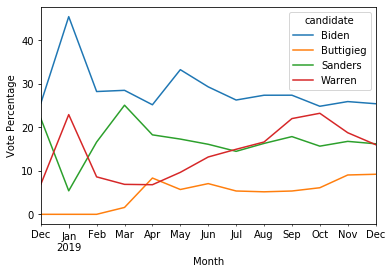

In [43]:
dfplot = df.plot()
dfplot.set(xlabel="Month", ylabel="Vote Percentage")

# Step 3 - Fitting Data for Time Series Analysis for Forecasting
## We want to forecast the upcoming months based on the current trends of the polls. To do this, we are going to use simple linear regression and also polynomial regression to see the differences. 
### The first step is to fit the linear regression for each candidate, which will be the sum of least squares. We do this by using the linear regression function. Next, we store the forecasted results using the predict function

In [6]:
months = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # months that we have used so far
prediction_months = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] # months that we would potentially predict
monthsdf = pd.DataFrame(months)
predictionmonthsdf = pd.DataFrame(prediction_months)

X = monthsdf.values.reshape(-1, 1)
prediction_months = predictionmonthsdf.values.reshape(-1, 1)
Y1 = df['Biden'].values.reshape(-1, 1)
Y2 = df['Warren'].values.reshape(-1, 1)
Y3 = df['Sanders'].values.reshape(-1, 1)
Y4 = df['Buttigieg'].values.reshape(-1, 1)

linear_regressor_biden = LinearRegression()  # create object for the class
linear_regressor_biden.fit(X, Y1) # fit Biden's linear regression
Y_current_biden = linear_regressor_biden.predict(X) # store Biden's linear regression results for the months collected so far to plot for illustrative purposes
Y_pred_biden = linear_regressor_biden.predict(prediction_months) # predict the upcoming months based on the regression results

linear_regressor_warren = LinearRegression()  # create object for the class
linear_regressor_warren.fit(X, Y2) # fit Warren's linear regression
Y_pred_warren = linear_regressor_warren.predict(prediction_months) # predict the upcoming months based on the regression results

linear_regressor_sanders = LinearRegression()  # create object for the class
linear_regressor_sanders.fit(X, Y3) # fit Sanders' linear regression
Y_pred_sanders = linear_regressor_sanders.predict(prediction_months) # predict the upcoming months based on the regression results

linear_regressor_buttigieg = LinearRegression()  # create object for the class
linear_regressor_buttigieg.fit(X, Y4) # fit Buttigieg's linear regression
Y_pred_buttigieg = linear_regressor_buttigieg.predict(prediction_months) # predict the upcoming months based on the regression results

## To show the linear regression results, below is the fitted regression for Biden. We can just use the plt functionality to show the scatter plot and the regression line. 0 on the x-axis corresponds to December 2018, and 12 corresponds to December 2019, with every other month in between

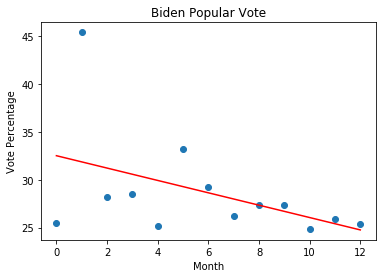

In [7]:
plt.scatter(X, Y1)
plt.title('Biden Popular Vote') 
plt.xlabel('Month') 
plt.ylabel('Vote Percentage') 
plt.plot(X, Y_current_biden, color='red')
plt.show()

## To show the prediction based on the linear regression, below is the prediction for Biden. 13 on the x-axis corresponds to January 2020, and 17 corresponds to May 2020, with every other month in between. Again, we just use the plt functionality.

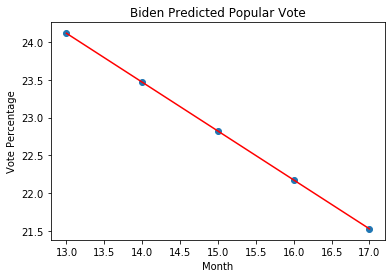

In [8]:
plt.title('Biden Predicted Popular Vote') 
plt.xlabel('Month') 
plt.ylabel('Vote Percentage') 
plt.scatter(prediction_months[:5], Y_pred_biden[:5])
plt.plot(prediction_months[:5], Y_pred_biden[:5], color='red')
plt.show()

## Next, we want to see if a polynomial regression differs greatly from the linear regression. To do this, we can use the polynomial functions from sklearn. We want to just use 2 for the polynomial to show a more dynamic trend while also trying to avoid overfitting.

In [29]:
poly = PolynomialFeatures(degree = 2) # set the polynomial 
X_poly = poly.fit_transform(X) # set the months that we have gathered
  
poly.fit(X_poly, Y1) # these three lines fit the polynomial regression to Biden
bidenpoly = LinearRegression() 
bidenpoly.fit(X_poly, Y1) 

bidenpolypred = bidenpoly.predict(poly.fit_transform(prediction_months)) # this stores the polynomial regression for the forecasting months

## Now we can plot what the fitted polynomial regression was for Biden, along with the forecasted results. We use the plt functionality for this. Again, 0 on the x-axis corresponds to December 2018, and 12 corresponds to December 2019, with every other month in between  for the first graph. 13 on the x-axis corresponds to January 2020, and 17 corresponds to May 2020, with every other month in between for the second graph.

### The results are different when compared to the linear regression. Biden is forecasted to have about 21.5 percent of the vote based on the linear regression, while the polynomial regression predicts about 22.75 percent. Though the absolute number is different, this may not affect the relative ranking compared to the other candidates. 

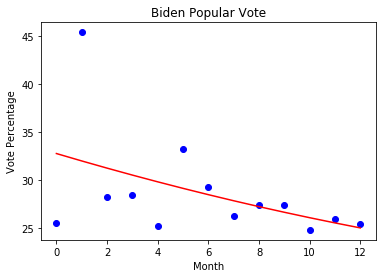

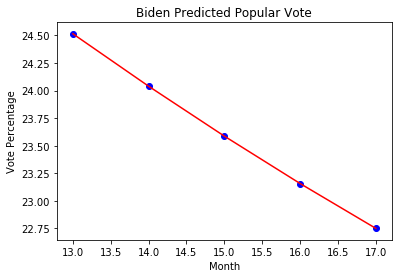

In [30]:
plt.scatter(X, Y1, color = 'blue') 
plt.plot(X, bidenpoly.predict(poly.fit_transform(X)), color = 'red') 
plt.title('Biden Popular Vote') 
plt.xlabel('Month') 
plt.ylabel('Vote Percentage') 
plt.show()
plt.scatter(prediction_months[:5], bidenpoly.predict(poly.fit_transform(prediction_months[:5])), color = 'blue')
plt.plot(prediction_months[:5], bidenpoly.predict(poly.fit_transform(prediction_months[:5])), color = 'red') 
plt.title('Biden Predicted Popular Vote') 
plt.xlabel('Month') 
plt.ylabel('Vote Percentage') 
plt.show()

## Next, we are going to fit the polynomial regression for the other 3 candidates using the same method that we did for Biden.

In [31]:
poly.fit(X_poly, Y2) 
warrenpoly = LinearRegression() 
warrenpoly.fit(X_poly, Y2)
warrenpolypred = warrenpoly.predict(poly.fit_transform(prediction_months))

poly.fit(X_poly, Y3) 
sanderspoly = LinearRegression() 
sanderspoly.fit(X_poly, Y3)
sanderspolypred = sanderspoly.predict(poly.fit_transform(prediction_months))

poly.fit(X_poly, Y4) 
buttigiegpoly = LinearRegression() 
buttigiegpoly.fit(X_poly, Y4)
buttigiegpolypred = buttigiegpoly.predict(poly.fit_transform(prediction_months))

# Step 4 - Concatenating Data to Show Relative Results
## Now that we have fit all of the linear and polynomial regression data for the 4 candiates, we want to concatenate all of them so we can plot them on the same graph. We do this using pandas dataframes

In [32]:
index = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] # these are the months that we are going to show, with 13 being Jan 2020 and so on
columns = ["Biden", "Warren", "Sanders", "Buttigieg"] # set the column names
columns = pd.DataFrame(columns) # convert to dataframe
dfbiden = pd.DataFrame(Y_pred_biden, index = index) # set the dataframes for each of the candidate from the linear regression
dfwarren = pd.DataFrame(Y_pred_warren, index = index)
dfsanders = pd.DataFrame(Y_pred_sanders, index = index)
dfbuttigieg = pd.DataFrame(Y_pred_buttigieg, index = index)

dfbidenpoly = pd.DataFrame(bidenpolypred, index = index) # set the dataframes for each of the candidate from the polynomial regression
dfwarrenpoly = pd.DataFrame(warrenpolypred, index = index)
dfsanderspoly = pd.DataFrame(sanderspolypred, index = index)
dfbuttigiegpoly = pd.DataFrame(buttigiegpolypred, index = index)

result = pd.concat([dfbiden, dfwarren, dfsanders, dfbuttigieg], axis=1) # concatenate the linear regression results
polyresult = pd.concat([dfbidenpoly, dfwarrenpoly, dfsanderspoly, dfbuttigiegpoly], axis=1) # concatenate the polynomial regression results

result.columns = ["Biden", "Warren", "Sanders", "Buttigieg"] # set the column names for the new concatenated dataframes
polyresult.columns = result.columns

# the remaining lines change the index of both dataframes so that we can show the month on the x-axis when we plot instead of a number 
result.index = ["01-01-2020", "02-01-2020", "03-01-2020", "04-01-2020", "05-01-2020", "06-01-2020", "07-01-2020", "08-01-2020", "09-01-2020"
               ,"10-01-2020", "11-01-2020", "12-01-2020", "01-01-2021"]
result.index = pd.to_datetime(result.index)
polyresult.index = result.index
polyresult.index = pd.to_datetime(polyresult.index) 

# Step 5 - Plotting the Linear and Polynomial Regressions to Show Relative Results

## Now we can plot the linear regression using the .plot functionality from pandas

### We can see from these results that while the absolute voting percentage changes for each of the candidates, the final result is still Warren winning, followed by Biden in 2nd, Sanders in 3rd, and Buttigieg in 4th

[Text(0, 0.5, 'Vote Percentage'), Text(0.5, 0, 'Month')]

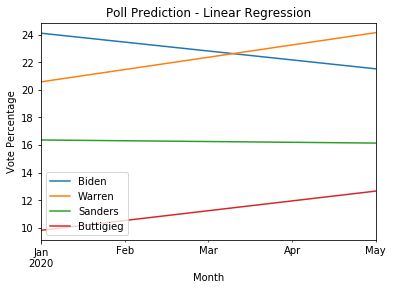

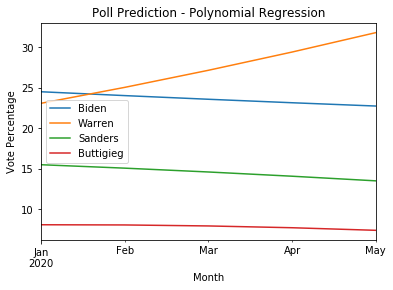

In [36]:
linearresultplot = result[0:5].plot(title= "Poll Prediction - Linear Regression", legend=True)
linearresultplot.set(xlabel="Month", ylabel="Vote Percentage")

polyresultplot = polyresult[0:5].plot(title= "Poll Prediction - Polynomial Regression", legend=True)
polyresultplot.set(xlabel="Month", ylabel="Vote Percentage")

# Step 6 - Comparing Twitter Popularity to Polling Results

## While we have used regression analysis to forecast the potential election results, we want to see if these candidates' popularity on Twitter accurately represents the polling results. To do this, we want to take the total number of likes and retweets for each candidiate and compare them to the current polling percentages

### To do this, we are going to use the Twitter API: tweepy

In [37]:
import tweepy as tw     # To consume Twitter's API
consumer_key = '9Ge3hhpeylVGr3mTGFm040xW6'
consumer_secret ='mx1xIzA8cgj7wyNeNBDik0HtuJVpDcL2NxijwyR2f1H6jkpylc'
access_token = '851496285844586498-fmzeILSNNRDo8su4ykYspmJjLaaoMoc'
access_token_secret = 'oFpauMSnByatXirKCl9ejJ3Dec4VJKNM0uxJ6VSVoQZtd'
# Access and authorize our Twitter credentials from credentials.py
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

# create dictionary so we can loop through the candidates' Twitter accounts
tusernames = {'Biden':'JoeBiden',
              'Warren':'ewarren',
              'Sanders':'BernieSanders',
              'Buttigieg':'PeteButtigieg'}

# create the blank dataframe that all of the Twitter results will do into
twitteranalysis = pd.DataFrame()

# this loop takes the most recent 200 Tweets for each candidate - as that is the max limit for the API - and the corresponding dates, likes, and retweets
for i in tusernames:
    data = []
    user = api.get_user(tusernames[i])
    screenname = user.screen_name
    tweets = api.user_timeline(screen_name=screenname, count=200)
    data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
    data['Candidate'] = np.array(i)
    data['Date'] = np.array([tweet.created_at for tweet in tweets])
    data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
    data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

# this appends the most recent candidate's Tweet data into the twitteranalysis dataframe
    twitteranalysis = twitteranalysis.append(data)

# this prints the count of the twitteranalysis dataframe to confirm that the data was pulled correctly. If it was pulled correctly, all of the numbers should be 800
print(twitteranalysis.count())

Tweets       800
Candidate    800
Date         800
Likes        800
RTs          800
dtype: int64


## Lastly, we are going to plot the results of the Twitter popularity to the polling numbers

### As shown by the results, Twitter popularity does not seem to accurately reflect the percent polling that each candidate receives. Bernie Sanders is the most popular on Twitter, with the most likes and retweets, but he is just about tied with Warren in polling at 2nd, with both of those candidates trailing Biden by a considerable amount. Additionally, Buttigieg is about as popular on Twitter as Warren is, but his polling numbers are considerably behind Warren's

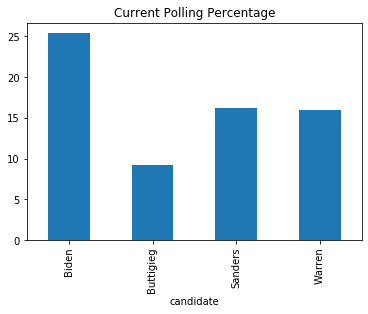

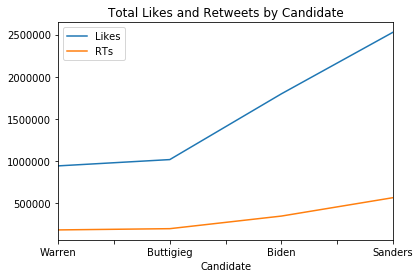

In [63]:
currentpolls = df
# using iloc of -1 to show the most recent month of polling numbers, Dec 2019
currentpolls.iloc[-1].plot.bar(title = "Current Polling Percentage") 
twitteranalysis = twitteranalysis.groupby(['Candidate'])['Likes', 'RTs'].agg('sum')
twitteranalysis.sort_values(by=['Likes', 'RTs']).plot(title = "Total Likes and Retweets by Candidate")